# **Classification of Cerebral Microhemorrhage V2**

### First Step: Detect slices with microbleed

**Dataset** - available in the directory: '/notebooks/datasets/TGO/CAA_MRI_T2star'. 
 
**Achitecture** - DenseNet121 

**Loss Function** - Cross Entropy

**Optimizer** - Adam
<!--
**Metrics** - Mean dice (compute mean dice)-->

In [1]:
#imports
import os
import glob
import math
import shutil
from livelossplot import PlotLosses
#import pickle
import datetime
import time

import pandas as pd
import numpy as np
#import numpy.ma as ma
from sklearn.model_selection import train_test_split
from sklearn.utils   import shuffle
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
#torch
import torch
import torch.nn as nn
from   torch.nn import CrossEntropyLoss
from   torch.optim import SGD, Adam
import torch.optim as optim

#from model import ResNet
#from torchsummary import summary
from torchinfo import summary
#monai
from monai.networks.nets import UNet, DenseNet, AttentionUnet
from monai.utils import set_determinism, first
#from monai.networks.layers import Norm
from monai.networks.layers.factories import Conv, Norm, Pool
from monai.networks.utils import one_hot, predict_segmentation
#from monai.data.image_reader import NibabelReader
from monai.config import print_config
from monai.data import Dataset, DataLoader, NibabelReader, decollate_batch
from monai.inferers import sliding_window_inference
#from monai.losses import DiceLoss
from monai.metrics import get_confusion_matrix, compute_confusion_matrix_metric, ConfusionMatrixMetric
from monai.optimizers import Novograd
from monai.transforms import (
    #import necessary transforms
    Activations,
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureType,
    LabelFilterd,
    LoadImaged,
    MapTransform,
    Orientationd,
    RandAffined,
    RandFlipd,
    RandRotated,
    Resized,
    ScaleIntensityRanged,
    ScaleIntensityd,
    SpatialPadd,
    ToTensord
)

In [2]:
#constants
#debuging
DEBUG = False

#device
#DEVICE = torch.device("cpu") #use cpu
DEVICE = torch.device("cuda:0") #use GPU 

#Determinism
RSEED = 12345678
set_determinism(seed = RSEED) #enable deterministic training globally for python, numpy and pytorh in one line

#Dataset and Dataloader
LABEL_ID = 1  #microbleeds
NUM_WORKERS = 0
BATCH_SIZE = 10
SHUFFLE = True

#training
LOAD_BEST_CHECKPOINT = False#True
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
MOMENTUM = 0.95
VAL_INTERVAL = 1  # do validation for every epoch
NUM_CLASSES = 2
TRAIN_EPOCH = 200
DROPOUT = 0.2
AUGMENTATION_PROB = 0.3


#date
now = datetime.datetime.now()
date_str = now.strftime("%Y_%m_%d")
hour_str = now.strftime("%Hh_%Mm")
DATE_STR = f"Data{date_str}_Hora{hour_str}" #to create a new checkpoint

#label to check
LABEL = {
    "micro":1,
    "macro":2
}
CHOSEN_LABEL = "micro"

#Paths
DATASETS_DIR = "/notebooks/datasets/TGO" #datasets path
DATA_DIR = f"{DATASETS_DIR}/CAA_MRI_T2star" #path to the dataset
NUMPY_DIR = f"{DATASETS_DIR}/CAA_MRI_T2star_numpy"
RESULTS_PATH_CLASS = "./Results/Results_Classification" #path to save the model's results
RESULTS_PATH_SEGMENT = "./Results/Results_segmentation" #path to save the model's results
TRIAL_NAME = f"Results_{TRAIN_EPOCH}epoch_{DATE_STR}" #name of the atempt (to create a folder in the path set above)

CHECKPOINT_PATH_CLASS = f"{RESULTS_PATH_CLASS}/{TRIAL_NAME}"
CHECKPOINT_PATH_SEGMENT = f"{RESULTS_PATH_SEGMENT}/{TRIAL_NAME}"


NUMPY_FILE = f'{NUMPY_DIR}/np_{CHOSEN_LABEL}.npz' #numpy file name for both scans and masks

if(DEBUG):
    print_config()

In [3]:
def create_Folder(FolderName):
    try:
        os.makedirs(FolderName) #recursivo
        print(f"Successfully created the directory {FolderName}")
    except OSError:
        print(f"The folder {FolderName} already exist")
        
def test_next_slice(image, index, label):
    try:
        if(image[:, :, index].max() == label):
            if(image[:, :, index + 1].max() != label):
                return True
    except:
        return False
    return False

def test_previous_slice(image, index, label):
    try:
        if(image[:, :, index].max() == label):
            if(image[:, :, index - 1].max() != label):
                return True
    except:
        return False
    return False

In [4]:
def nii_to_np(save = False):
    scans_files = glob.glob(f"{DATA_DIR}/*/*/[!mask]*.nii.gz")
    masks_files = glob.glob(f"{DATA_DIR}/*/*/mask.nii.gz")
    output_scans = []
    output_masks = []
    total_scans = 0
    used_scans = 0
    discarted_scans  = 0
    discarted_slices = 0
    for i in range(len(scans_files)):
        scan = scans_files[i]
        mask = masks_files[i]
        read_scan = NibabelReader().read(scan).get_fdata()
        read_mask = NibabelReader().read(mask).get_fdata()
        read_mask = np.where(read_mask != LABEL[CHOSEN_LABEL], 0, read_mask) #select only the correct label
        total_scans += 1
        read_scan /= read_scan.max() #normalize intensity
        if(read_mask.max() == LABEL[CHOSEN_LABEL]): #microbleed in exam
            used_scans += 1
            for slice_index in range(read_scan.shape[2]):
                read_scan_slice = read_scan[:, :, slice_index]
                read_mask_slice = read_mask[:, :, slice_index]
                if(read_mask_slice.max() == LABEL[CHOSEN_LABEL]): #microbleed in slice
                    output_scans.append(read_scan_slice)
                    output_masks.append(read_mask_slice)
                    if test_next_slice(read_scan, slice_index, LABEL[CHOSEN_LABEL]):
                        #add next slice if the current has but next does not
                        output_scans.append(read_scan[:, :, slice_index + 1])
                        output_masks.append(read_mask[:, :, slice_index + 1])
                    if test_previous_slice(read_scan, slice_index, LABEL[CHOSEN_LABEL]):
                        #add previous slice if the current has but previous does not
                        output_scans.append(read_scan[:, :, slice_index - 1])
                        output_masks.append(read_mask[:, :, slice_index - 1])
                else:
                    discarted_slices += 1
        else: #does not have the selected label
            #add 1/3 of the non label images
            start_slice = read_scan.shape[2] // 3 #1/3
            for slice_index in range(start_slice, 2 * start_slice):
                    output_scans.append(read_scan[:, :, slice_index])
                    output_masks.append(read_mask[:, :, slice_index])
    output_scans = np.array(output_scans)
    output_masks = np.array(output_masks)
    output_scans, output_masks = shuffle(output_scans, output_masks, random_state = RSEED) #shuffle both
    print(f"Scan_list: {output_scans.shape}")
    print(f"Using {used_scans}/{total_scans}exams")
    print(f"Discarted {discarted_slices}")
    if(save):
        if(not os.path.exists(NUMPY_DIR)):
            create_Folder(NUMPY_DIR)
        #save the np files, using compressed format
        print("Started saving")
        np.savez_compressed(NUMPY_FILE, scans = output_scans, masks = output_masks) #save images
        print(f"Saved file {NUMPY_FILE}")
        #np.savez_compressed(MASKS_NP_FILE, output_masks) #save corresponding labels
        #print(f"Saved file {MASKS_NP_FILE}")
        print("Done")

if(not os.path.exists(NUMPY_FILE)):
    print(f"File {NUMPY_FILE} not found, creating...")
    nii_to_np(save = True) #save to true if files need to be saved
else:
    print(f"File {NUMPY_FILE} found, continuing!")

File /notebooks/datasets/TGO/CAA_MRI_T2star_numpy/np_micro.npz found, continuing!


### CHECK AND VISUALIZE DATA 

In [5]:
def new_set(scans_list, masks_list):
    label_with =    1
    label_without = 0
    return [
        {"scan": scan, "mask" : mask, "label": label_with if mask.max() != 0 else label_without}
        for scan, mask in zip(scans_list, masks_list)
    ]

def load_numpy():
    #load numpy arrays
    exams = np.load(NUMPY_FILE, allow_pickle = True)
    scans_files = exams["scans"]
    masks_files = exams["masks"]
  
    train_scans, val_scans, train_masks, val_masks = train_test_split(scans_files, masks_files, test_size = 0.2, random_state = RSEED)


    train_set = new_set(train_scans, train_masks)

    val_set = new_set(val_scans, val_masks)
    
    print("="*20)
    print(f"Total de imagens:   {scans_files.shape}")
    print(f"Casos de treino:    {train_scans.shape}")
    print(f"Casos de validação: {val_scans.shape}")
    print("="*20)

    return train_set, val_set

#função para colocar o label por extenso
def output_label(label, mapping = 'label'):
    if (mapping == 'ext'):
        output_mapping = { 0 : "No Hemorrhage", 1 : "With Micro Hemorrhage", 2 : "With Macro Hemorrhage"  }
    elif (mapping == 'ext2'):
        output_mapping = { "0" : "No Hemorrhage", "1" : "With Micro Hemorrhage", "2" : "With Macro Hemorrhage" }
    else:
        output_mapping = { 0 : "No Hemorrhage", 1 : "With Micro Hemorrhage", 2 : "With Macro Hemorrhage" }
    label_input = (label.item() if type(label) == torch.Tensor else label) #pode ser um tensor
    return output_mapping[label_input]

train_set, val_set = load_numpy()

Total de imagens:   (454,)
Casos de treino:    (363,)
Casos de validação: (91,)


-----------------------------------casos_treino-----------------------------------
casos: 363
['No Hemorrhage', 'With Micro Hemorrhage']
['0', '1']
[158 205]
363


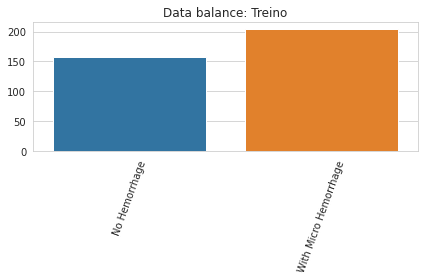

-----------------------------------casos_validação-----------------------------------
casos: 91
['No Hemorrhage', 'With Micro Hemorrhage']
['0', '1']
[37 54]
91


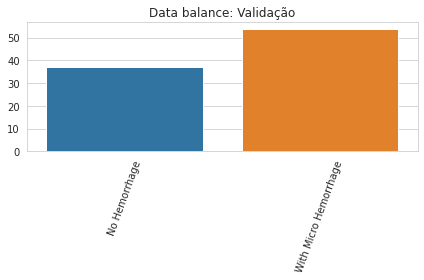

In [6]:
#verificar o balanceamento dos dados
def visualize_holdout_balance(labels, class_names, titulo):                          
    with sns.axes_style('whitegrid'):#sns.set_style('whitegrid'):
        print("casos:",len(labels))
        x, y = np.unique(labels, return_counts = True)
        x_ext = [class_names(n)  for n in x]#[n] em vez de (n)
        print(x_ext)
        print([str(n) for n in x])
        print(y)
        print(np.sum(y))
        grafico = sns.barplot(x_ext, y)
        grafico.set_title(f'Data balance: {titulo}')
        plt.xticks(rotation = 70)
        plt.tight_layout()
        #plt.savefig('data_balance_MLP.png')
        plt.show()
        
print("-----------------------------------casos_treino-----------------------------------")   
visualize_holdout_balance([train_case["label"] for train_case in train_set], output_label, 'Treino')
print("-----------------------------------casos_validação-----------------------------------")   
visualize_holdout_balance([val_case["label"] for val_case in val_set], output_label, 'Validação')

In [7]:
def transforms():
    train_transform = Compose(
        [
            AddChanneld(keys = ["scan", "mask"]),
            Resized(keys = ["scan", "mask"], spatial_size = (256, 256), mode = ('bilinear'), align_corners = True),
            ScaleIntensityd(keys = ["scan", "mask"], minv = 0, maxv = 1),
            #augmentation 
            RandFlipd(keys = ["scan", "mask"], spatial_axis = 0, prob = AUGMENTATION_PROB),
            RandRotated(keys = ["scan", "mask"], range_x = 10 * (math.pi/180), prob = AUGMENTATION_PROB), #rotação em radianos
            #RandAffined(keys = ["scan"], prob = AUGMENTATION_PROB),
            ToTensord(keys = ["scan", "mask", "label"]),
        ]
    )
    val_transform = Compose(
        [
            AddChanneld(keys = ["scan", "mask"]),
            Resized(keys = ["scan", "mask"], spatial_size = (256, 256), mode = ('bilinear'), align_corners = True),
            ScaleIntensityd(keys = ["scan", "mask"], minv = 0, maxv = 1),
            ToTensord(keys = ["scan", "mask", "label"]),
        ]
    )
    return train_transform, val_transform

train_transform, val_transform = transforms() #initialize transforms

def dataloader(train_files, train_transform, val_transform, val_files):
    train_ds = Dataset(data = train_files, transform = train_transform)
    train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = SHUFFLE, num_workers = NUM_WORKERS)
    train_loader_all = DataLoader(train_ds, batch_size = len(train_ds), shuffle = SHUFFLE, num_workers = NUM_WORKERS)
    val_ds = Dataset(data = val_files, transform = val_transform)
    val_loader = DataLoader(val_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS)
    val_loader_all = DataLoader(val_ds, batch_size = len(val_ds), num_workers = NUM_WORKERS)

    return train_loader, val_loader, train_loader_all, val_loader_all #initialize dataloader

train_loader, val_loader, train_loader_all, val_loader_all = dataloader(train_set, train_transform, val_transform, val_set) #initialize dataloader

Train
Image shape: torch.Size([10, 1, 256, 256]), Mask shape: torch.Size([10, 1, 256, 256]), Label shape: torch.Size([10])


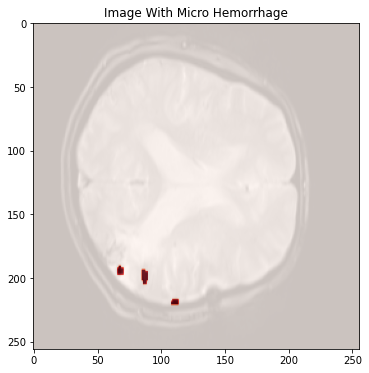

Validation
Image shape: torch.Size([10, 1, 256, 256]), Mask shape: torch.Size([10, 1, 256, 256]), Label shape: torch.Size([10])


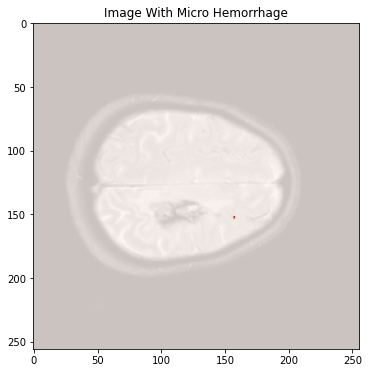

In [10]:
def check_transforms(loader):
    check_data = first(loader)
    image, mask, label = (check_data["scan"], check_data["mask"], check_data["label"])
    print(f"Image shape: {image.shape}, Mask shape: {mask.shape}, Label shape: {label.shape}")
    image, mask, label = image[0][0], mask[0][0], label[0]
    plt.figure("Check", (6, 6))
    plt.title(f"Image {output_label(label)}")
    plt.imshow(image, cmap = "gray")
    plt.imshow(np.where(mask != 0, mask, 0), cmap = 'Reds', alpha = 0.8)#'jet'
    plt.show()


print(f"{10 * '='}\nTrain\n{10 * '='}")
check_transforms(train_loader)
print(f"{10 * '='}\nValidation\n{10 * '='}")
check_transforms(val_loader)

### Define the model

In [11]:
def get_model_classification(lr_rate, weight_decay, momentum):
    model = DenseNet(spatial_dims = 2, 
                     in_channels = 1,
                     out_channels = NUM_CLASSES, 
                     dropout_prob = DROPOUT).to(DEVICE)

    loss_function = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr_rate)
    
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #optimizer, factor=0.1, patience=5, verbose=True)
    return model, loss_function, optimizer

model, loss_function, optimizer = get_model_classification(LEARNING_RATE, WEIGHT_DECAY, MOMENTUM) #scheduler, scaler
print(summary(model, (BATCH_SIZE, 1, 256, 256), verbose = 0))

Layer (type:depth-idx)                        Output Shape              Param #
DenseNet                                      --                        --
├─Sequential: 1-1                             [10, 1024, 8, 8]          --
│    └─Conv2d: 2-1                            [10, 64, 128, 128]        3,136
│    └─BatchNorm2d: 2-2                       [10, 64, 128, 128]        128
│    └─ReLU: 2-3                              [10, 64, 128, 128]        --
│    └─MaxPool2d: 2-4                         [10, 64, 64, 64]          --
│    └─_DenseBlock: 2-5                       [10, 256, 64, 64]         --
│    │    └─_DenseLayer: 3-1                  [10, 96, 64, 64]          45,440
│    │    └─_DenseLayer: 3-2                  [10, 128, 64, 64]         49,600
│    │    └─_DenseLayer: 3-3                  [10, 160, 64, 64]         53,760
│    │    └─_DenseLayer: 3-4                  [10, 192, 64, 64]         57,920
│    │    └─_DenseLayer: 3-5                  [10, 224, 64, 64]         62,

In [12]:
def test_folder(path):
    if(not os.path.exists(path)):#if the folder doesn't exist create it
        try:
            os.makedirs(path)#recursivo
            print(f"Successfully created the directory {path}")
        except OSError:
            print(f"The folder {path} already exist")
        
def get_best_checkpoint(model_name = ""):
    '''
    Returns the most recent best checkpoint to start the training
    '''
    if(model_name == "segmentation"):
        best_checkpoint_list = glob.glob(f"{RESULTS_PATH_SEGMENT}/*/BestCheckpoint/*.pt")
    elif(model_name == "classification"):
        best_checkpoint_list = glob.glob(f"{RESULTS_PATH_CLASS}/*/BestCheckpoint/*.pt")
    else:
        return ""
    the_best = ["", 0]
    for checkpoints in best_checkpoint_list:
        if(os.path.getctime(checkpoints) > the_best[1]):
            the_best[1] = os.path.getctime(checkpoints)
            the_best[0] = checkpoints
    return the_best[0]

def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # Loads the schedulers state
    #scheduler.load_state_dict(checkpoint['scheduler'])
    print ('=> Loading checkpoint')
    return model, optimizer, checkpoint

def save_ckp(state, is_best, checkpoint_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model: path to save best model
    """
    test_folder(checkpoint_path)#if the folder doesn't exist create it
    test_folder(f"{checkpoint_path}/BestCheckpoint")#if the folder doesn't exist create it
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f"{checkpoint_path}/Checkpoint.pt")
    # if it is a best model, min validation loss
    if is_best:
        # copy that checkpoint file to best path given, best_model
        shutil.copyfile(f"{checkpoint_path}/Checkpoint.pt", f"{checkpoint_path}/BestCheckpoint/BestCheckpoint.pt")
        print ('=> Saving best checkpoint')

In [13]:
def train_model(model, loss_function, optimizer, n_epochs):
    liveloss = PlotLosses()
    best_metric = -1
    best_metric_epoch = -1
    starttime = time.perf_counter()
    
    if(LOAD_BEST_CHECKPOINT):
        # create checkpoint variable and add important data
        try:
            model, optimizer, checkpoint = load_ckp(get_best_checkpoint(), model, optimizer)
            start_epochs = checkpoint['epoch']
            n_epochs += start_epochs
        except Exception as e:
            print("Could not load checkpoint, continuing!")
    else:
        start_epochs = 0
    #initialize var
    func_output = {"model" : model}
    
    for epoch in range(start_epochs, n_epochs + 1):
        logs = {}
        print("=" * 10)
        print(f"epoch {epoch}/{n_epochs}")
        print("=" * 10)
                                      ##########################################
# ************************************************* TRAINING THE MODEL ************************************************* #
                                      ##########################################
        model.train()
        running_loss  = 0.0
        running_corrects  = 0.0
        
        for batch_data in train_loader:
            inputs = batch_data["scan"].to(DEVICE)
            labels = batch_data["label"].to(DEVICE)#.long()
            outputs = model(inputs) #predict
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1) ## Get predictions from the maximum value
            running_corrects += torch.sum(preds == labels.data)
            '''
            total_steps_train = len(train_ds) // BATCH_SIZE + 1 if len(train_ds) % BATCH_SIZE != 0 else len(train_ds) // BATCH_SIZE
            print(f"Step: {step:{len(str(total_steps_train))}}/{total_steps_train} | Train_loss: {loss.item():.4f} | Train_metric: {train_metric:.4f}")#
            '''
        #Loss
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.float() / len(train_loader.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item() 
                                      ##########################################
# ************************************************* VALIDATE THE MODEL ************************************************* #
                                      ##########################################
        model.eval()
        with torch.no_grad():
            running_loss  = 0.0
            running_corrects  = 0.0
            for val_data in val_loader:
                val_inputs = val_data["scan"].to(DEVICE)
                val_labels = val_data["label"].to(DEVICE)#.long()
                val_outputs = model(val_inputs)
                loss = loss_function(val_outputs, val_labels)
                running_loss += loss.detach() * val_inputs.size(0)
                _, preds = torch.max(val_outputs, 1) ## Get predictions from the maximum value
                running_corrects += torch.sum(preds == val_labels.data)
            epoch_loss = running_loss / len(val_loader.dataset)
            epoch_acc = running_corrects.float() / len(val_loader.dataset)
            logs['val_loss'] = epoch_loss.item()
            logs['val_accuracy'] = epoch_acc.item()
            # update checkpoint variable
            checkpoint = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            if epoch_acc > best_metric:
                best_metric = epoch_acc
                best_metric_epoch = epoch
                save_ckp(checkpoint, True, CHECKPOINT_PATH_CLASS)
                func_output["model"] = model
                print('Saved new best metric model')
        save_ckp(checkpoint, False, CHECKPOINT_PATH_CLASS) # save checkpoint
        #liveplots
        liveloss.update(logs)
        liveloss.send()
    #To return
    func_output["epoch"] = epoch
    func_output["logs"] = logs
    
    endtime = time.perf_counter()
    print(f"Train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")   
    print(f"Time spent: {endtime - starttime} seconds")
    
    return func_output

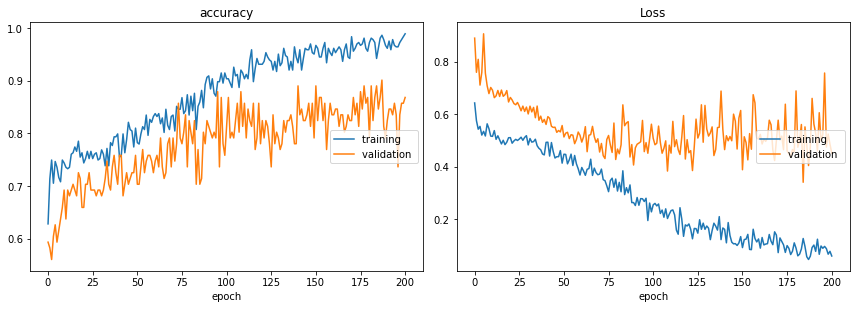

accuracy
	training         	 (min:    0.628, max:    0.989, cur:    0.989)
	validation       	 (min:    0.560, max:    0.901, cur:    0.868)
Loss
	training         	 (min:    0.046, max:    0.642, cur:    0.059)
	validation       	 (min:    0.340, max:    0.906, cur:    0.451)
Train completed, best_metric: 0.9011 at epoch: 187
Time spent: 2528.994588959962 seconds


In [14]:
#20%dropout
trained_model_output = train_model(model, loss_function, optimizer, TRAIN_EPOCH)

# Evaluate Model

=> Loading checkpoint
Real:[1] Previsão:[1]
Real:[1] Previsão:[0]
Real:[1] Previsão:[1]
Real:[0] Previsão:[0]
Real:[1] Previsão:[1]
Real:[1] Previsão:[1]
Real:[1] Previsão:[1]
Real:[1] Previsão:[1]
Real:[1] Previsão:[1]
Real:[0] Previsão:[0]
Real:[1] Previsão:[1]
Real:[0] Previsão:[1]
Real:[1] Previsão:[1]
Real:[0] Previsão:[0]
Real:[1] Previsão:[1]
Real:[1] Previsão:[1]
Real:[0] Previsão:[0]
Real:[0] Previsão:[0]
Real:[0] Previsão:[0]
Real:[1] Previsão:[1]
Accuracy: 0.901

Acertou:82 Falhou:9
              precision    recall  f1-score   support

           0       0.94      0.81      0.87        37
           1       0.88      0.96      0.92        54

    accuracy                           0.90        91
   macro avg       0.91      0.89      0.89        91
weighted avg       0.90      0.90      0.90        91



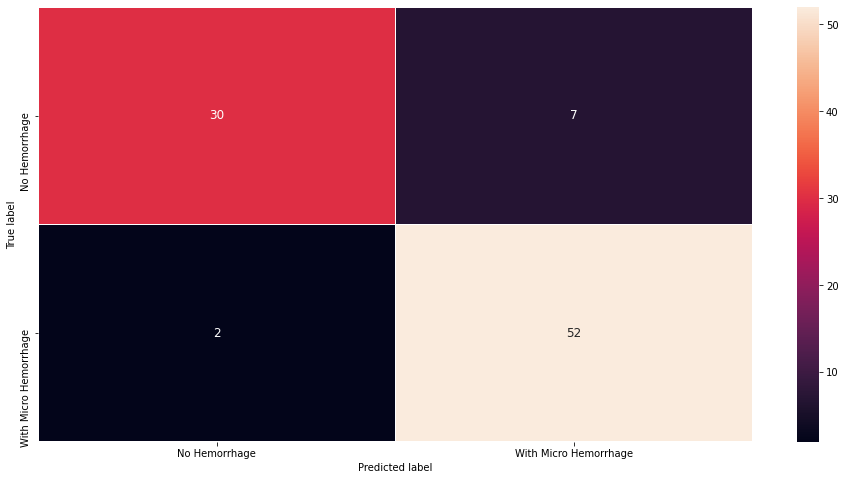

In [15]:
# Avaliar o modelo
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for batch_data in test_dl: 
        # avaliar o modelo com os casos de teste
        inputs = batch_data["scan"].to(DEVICE)
        labels = batch_data["label"].to(DEVICE) #.long()
        yprev = model(inputs)
        # retirar o array numpy
        yprev = yprev.detach().cpu().numpy()
        actual = labels.cpu().numpy()
        # converter para a class dos labels
        yprev = np.argmax(yprev, axis = 1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        # guardar
        predictions.append(yprev)
        actual_values.append(actual)
        break #só vai dar um batch
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_predictions(actual_values, predictions ):
    acertou = 0
    falhou  = 0
    primeiros = 0
    for r, p in zip(actual_values, predictions):
        if (primeiros < 20):
            print(f'Real:{r} Previsão:{p}') 
            primeiros += 1
        if (r == p): 
            acertou += 1  
        else: 
            falhou += 1
    # calcular a accuracy
    corrects = np.sum(predictions == actual_values)
    acc = corrects / len(predictions) #len(test_dl.dataset)
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'Acertou:{acertou} Falhou:{falhou}')


def display_confusion_matrix(cm, list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm, annot = True, xticklabels = list_classes, yticklabels = list_classes, annot_kws = {"size": 12}, fmt = 'g', linewidths = .5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 
    
# avaliar o modelo
model = trained_model_output["model"]
model, optimizer, checkpoint = load_ckp(get_best_checkpoint(), model, optimizer)#"classification"
actual_values, predictions = evaluate_model(val_loader_all, model)
display_predictions(actual_values, predictions )
print(classification_report(actual_values, predictions))
cr = classification_report(actual_values, predictions, output_dict = True)
list_classes = [output_label(n, 'ext2') for n in list(cr.keys())[ : NUM_CLASSES] ]
cm = confusion_matrix(actual_values, predictions)
display_confusion_matrix(cm, list_classes)

# Test model

Predict: 0
Ground Truth: 0


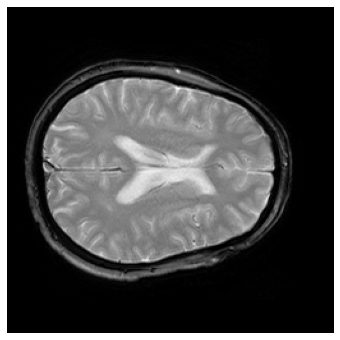

In [16]:
# fazer uma previsão utilizando um caso
def make_prediction(model, img, label):
    img = img.to(DEVICE)
    img = img[None, :]
    prediction = model(img).cpu().detach().numpy()[0].argmax()
    print(f"Predict: {prediction}\nGround Truth: {label}" )
    img = img.cpu()
    plt.figure("Check", (6, 6))
    plt.axis('off')
    plt.grid(b = None)
    plt.imshow(img[0,0], cmap = plt.get_cmap('gray'))
    plt.show()

check_data = next(iter(val_loader_all))
imagens, label = (check_data["scan"], check_data["label"])
make_prediction(model, imagens[3], label[3])

Exam shape: (512, 512, 24)
=> Loading checkpoint
Predict: 0 	Ground Truth: 0 	Correct? True


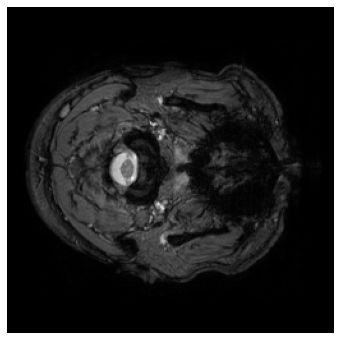

Predict: 1 	Ground Truth: 0 	Correct? False


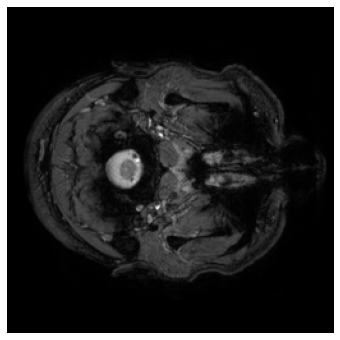

Predict: 1 	Ground Truth: 0 	Correct? False


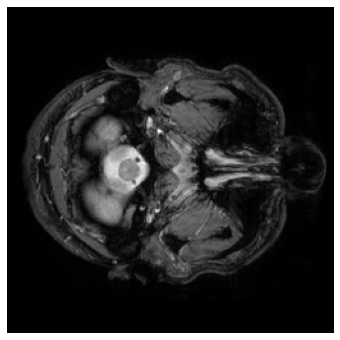

Predict: 1 	Ground Truth: 0 	Correct? False


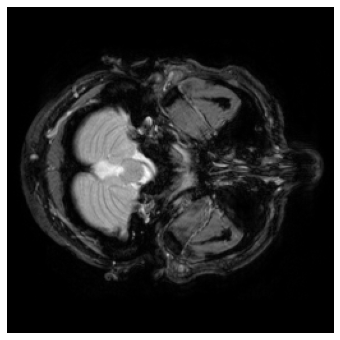

Predict: 0 	Ground Truth: 0 	Correct? True


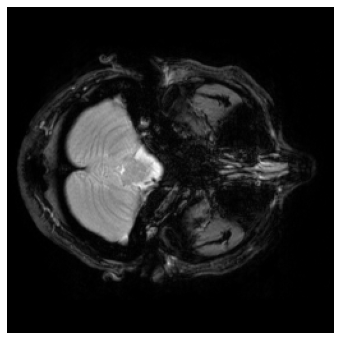

Predict: 0 	Ground Truth: 0 	Correct? True


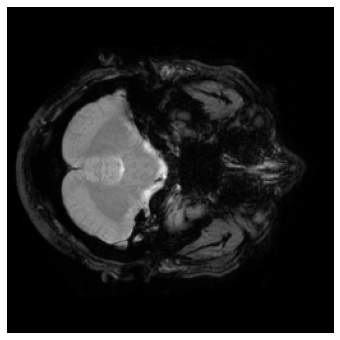

Predict: 0 	Ground Truth: 0 	Correct? True


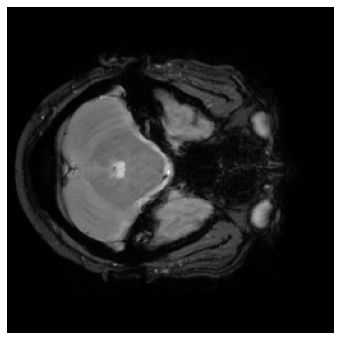

Predict: 0 	Ground Truth: 0 	Correct? True


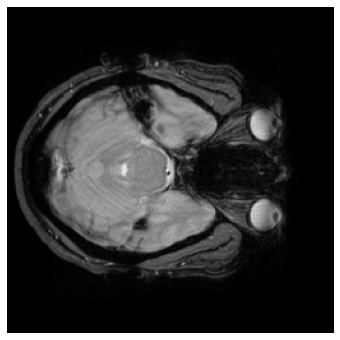

Predict: 0 	Ground Truth: 0 	Correct? True


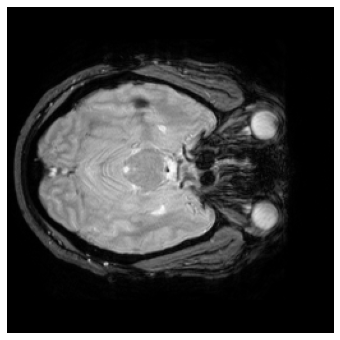

Predict: 0 	Ground Truth: 0 	Correct? True


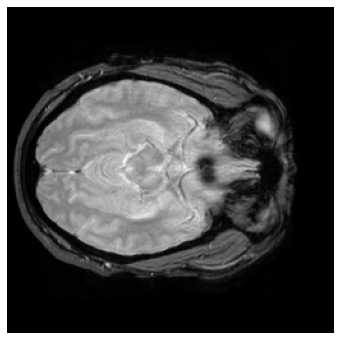

Predict: 1 	Ground Truth: 0 	Correct? False


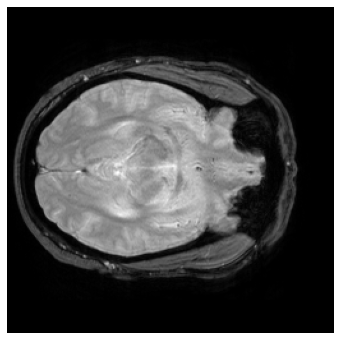

Predict: 1 	Ground Truth: 1 	Correct? True


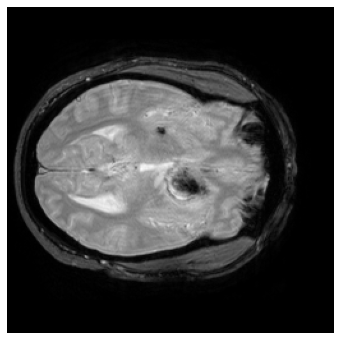

Predict: 1 	Ground Truth: 1 	Correct? True


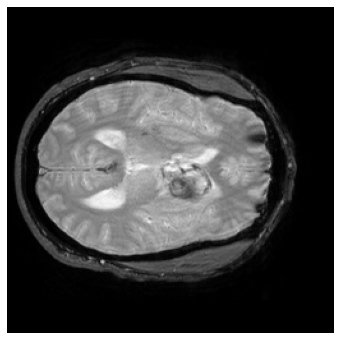

Predict: 1 	Ground Truth: 1 	Correct? True


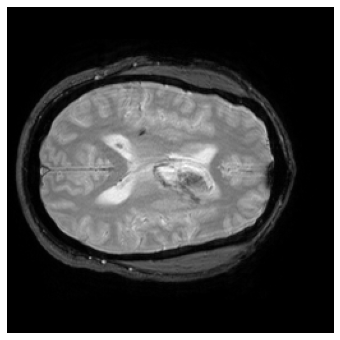

Predict: 1 	Ground Truth: 1 	Correct? True


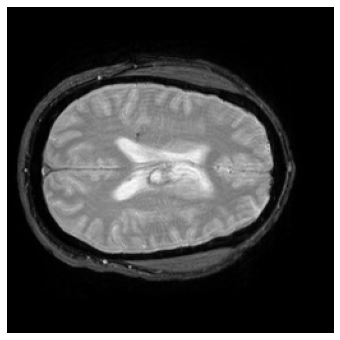

Predict: 1 	Ground Truth: 0 	Correct? False


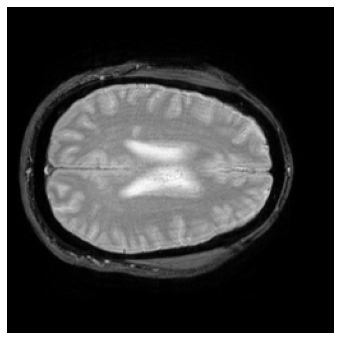

Predict: 1 	Ground Truth: 0 	Correct? False


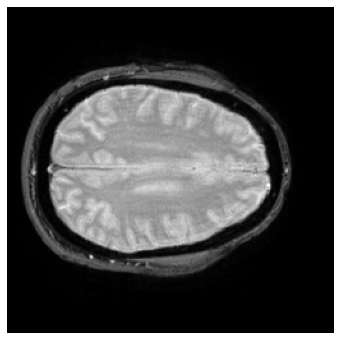

Predict: 1 	Ground Truth: 0 	Correct? False


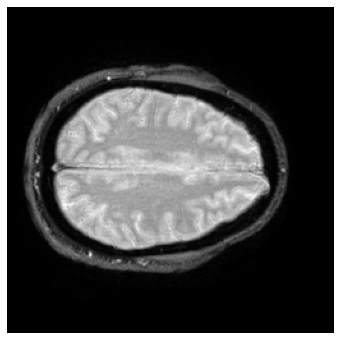

Predict: 1 	Ground Truth: 0 	Correct? False


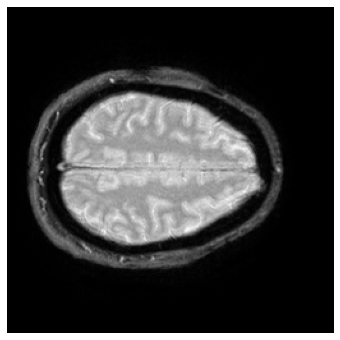

Predict: 1 	Ground Truth: 0 	Correct? False


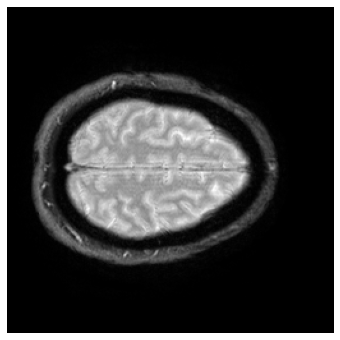

Predict: 1 	Ground Truth: 0 	Correct? False


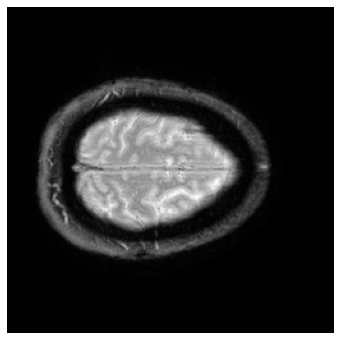

Predict: 1 	Ground Truth: 0 	Correct? False


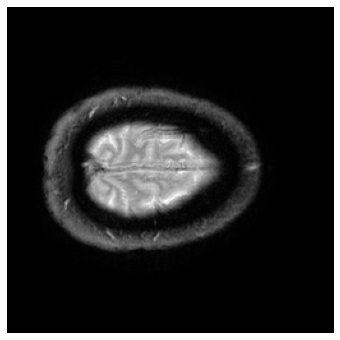

Predict: 1 	Ground Truth: 0 	Correct? False


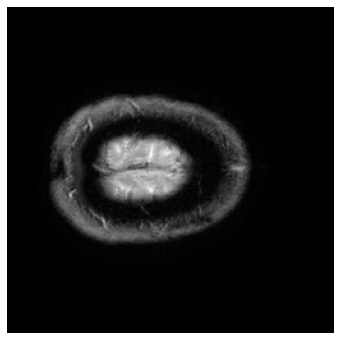

Predict: 1 	Ground Truth: 0 	Correct? False


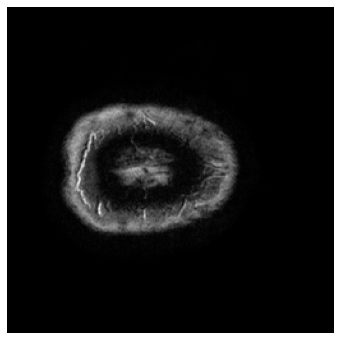

In [17]:
LOAD_BEST_CHECKPOINT = True
def print_img(img):
    plt.figure("Check", (6, 6))
    plt.axis('off')
    plt.grid(b = None)
    plt.imshow(img[0,0], cmap = plt.get_cmap('gray'))
    plt.show()

def make_prediction_exam(model):
    chosen = 0
    scan_path = glob.glob(f"{DATA_DIR}/*/*/[!mask]*.nii.gz")[chosen]
    mask_path = glob.glob(f"{DATA_DIR}/*/*/mask.nii.gz")[chosen]
    read_scan = NibabelReader().read(scan_path).get_fdata()
    read_mask = NibabelReader().read(mask_path).get_fdata()
    read_mask = np.where(read_mask != LABEL[CHOSEN_LABEL], 0, read_mask) #select only the correct label
    read_scan /= read_scan.max()
    sliced_scan = []
    sliced_mask = []
    prediction = []
    for i in range(read_scan.shape[2]):
        sliced_scan.append(read_scan[:,:,i])
        sliced_mask.append(read_mask[:,:,i])
    print(f"Exam shape: {read_scan.shape}")
    check_data = val_transform(new_set(sliced_scan, sliced_mask))
    if(LOAD_BEST_CHECKPOINT):
        model, _, _ = load_ckp(get_best_checkpoint(), model, optimizer)
    #print(check_data)
    for i in range(len(check_data)):
        img, label = (check_data[i]["scan"], check_data[i]["label"])
        img = img.to(DEVICE)
        img = img[None, :]
        prediction = model(img).cpu().detach().numpy()[0].argmax()
        print(f"Predict: {prediction} \tGround Truth: {label} \tCorrect? {prediction == label}" )
        img = img.cpu()
        print_img(img)
        
make_prediction_exam(model)